 **High-Frequency (Crypto price) trading rules using Machine Learning**
 
 Version 2.0 (Technical Indicators(market data))
 
 Momentum strategy + Meta-Labeling



# Contents

1. Financial Data and Bars 
 - Form Bars
 - Summary and plot


2. Getting Signals (Long position only)
 - Momentum strategy (RSI)


3. Labeling with Triple-Barrier Method
 - Form Symmetric Triple Barrier with the signals
 - Binary Labeling (Profit or Loss)


4. Prediction Model

 4.1. Get Features (X)
 - Market data & Technical Analysis
 - *Market Microstructure Features
 - *Macroeconomic Variables
 - *Fundamentals
 - *News Sentiments with NLP
 
 4.2. Feature Engineering
 - Feature Scaling (MinMaxScaler)
 - Dimension Reduction (PCA/ NL Autoencoder)
 
 4.2. Machine Learning Model
 - Hyperparameter tuning
 - AutoML with *autogluon* and select the best model
 - *Feature Importance
 - Results with PnL
 
 
5. Trading
 - *Bet Sizing
 - *Trading Simulation
 
 
5. Results
 - *Cumulative returns, Sharpe Ratio, Drawdown


In [1]:
# De Prado AMFL
import triple_barrier as tb #local

# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from scipy.stats import norm, moment

#feature
from sklearn import preprocessing
from sklearn.decomposition import PCA 

#ML
import autogluon as ag

# deep learning
import keras

# Technical analysis
import ta
import getTA #local
import tautil #local

# Backtesting pyfolio
#import pyfolio as pf

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
def figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.plot(close, linewidth=0.5,alpha=0.6)
    plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap=cmap, alpha=1)
    plt.colorbar()
    plt.title(title)
    plt.savefig('image/{}.png'.format(title))
    plt.show()

# Financial Data and Bars

## OHLCV Bar + Buy Volume

- Asset: ETH/USD 
- 5 minute data

In [4]:
df_raw = pd.read_csv('ethusd5min.csv')
df = df_raw.set_index('timestamp')
df.index = pd.to_datetime(df.index)

In [5]:
df

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2019-01-01 00:00:00,131.45,131.54,131.01,131.27,1269.12705,1546301099999,1.666154e+05,404,583.71526,7.665267e+04,0
2019-01-01 00:05:00,131.26,131.35,131.12,131.29,1601.91843,1546301399999,2.102706e+05,329,970.39345,1.273754e+05,0
2019-01-01 00:10:00,131.27,131.36,131.19,131.31,560.54337,1546301699999,7.359844e+04,255,237.78679,3.121957e+04,0
2019-01-01 00:15:00,131.30,131.36,131.25,131.30,651.89505,1546301999999,8.559326e+04,203,173.81466,2.282429e+04,0
2019-01-01 00:20:00,131.26,131.44,131.25,131.28,500.58218,1546302299999,6.572714e+04,275,232.22948,3.049598e+04,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13 23:40:00,1941.97,1943.71,1940.34,1943.25,392.24754,1626219899999,7.618761e+05,925,265.19319,5.150956e+05,0
2021-07-13 23:45:00,1943.24,1943.24,1932.66,1933.79,1233.82503,1626220199999,2.389417e+06,2173,612.61804,1.186551e+06,0
2021-07-13 23:50:00,1933.79,1935.73,1931.38,1933.40,1011.00253,1626220499999,1.954553e+06,1957,498.29748,9.634496e+05,0


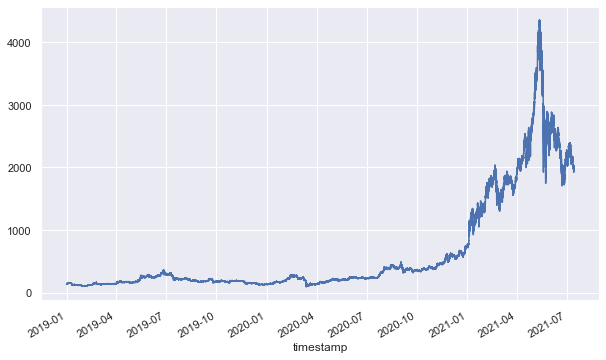

In [6]:
df.close.plot(figsize=(10,6))

In [7]:
# after 2021, there's huge updowns.
df = df.loc[:'2020-12':,:]

In [8]:
close = pd.to_numeric(df.close)
open = pd.to_numeric(df.open)
high = pd.to_numeric(df.high)
low = pd.to_numeric(df.low)
volume = pd.to_numeric(df.volume)
buy_volume = pd.to_numeric(df.tb_base_av)

## summary & plots

In [9]:
df_ohlcv = pd.DataFrame([open,high,low,close,volume]).T
df_ohlcv.describe()

,open,high,low,close,volume
count,209927.000000,209927.000000,209927.000000,209927.000000,209927.000000
mean,243.492061,243.887416,243.077421,243.494881,2190.583501
std,124.212462,124.446560,123.957276,124.216585,3165.919805
min,88.440000,93.590000,86.000000,88.350000,0.000000
25%,159.900000,160.120000,159.630000,159.900000,641.117305
50%,203.780000,204.150000,203.400000,203.780000,1258.037530
75%,278.355000,279.145000,277.605000,278.345000,2488.947350
max,754.980000,758.740000,753.500000,754.970000,105591.963390


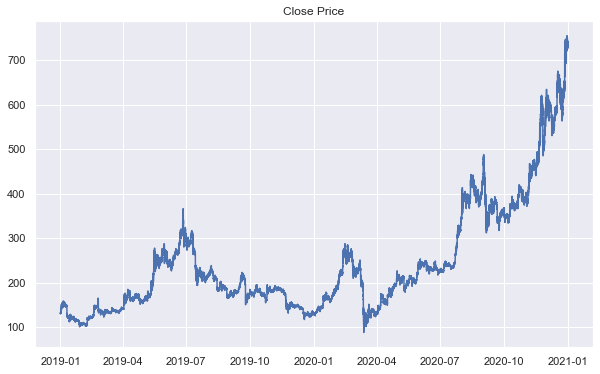

In [10]:
plt.figure(figsize=(10,6))
plt.title('Close Price')
plt.plot(close)
plt.savefig('image/close_price.jpg')
plt.show();

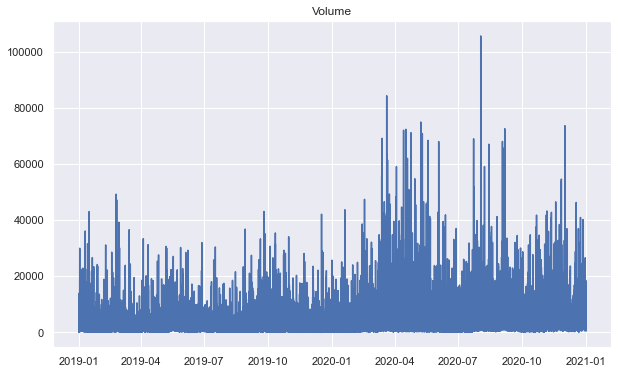

In [11]:
plt.figure(figsize=(10,6))
plt.title('Volume')
plt.plot(volume)
plt.savefig('image/volume.jpg')
plt.show();

In [12]:
of = buy_volume - (volume-buy_volume)

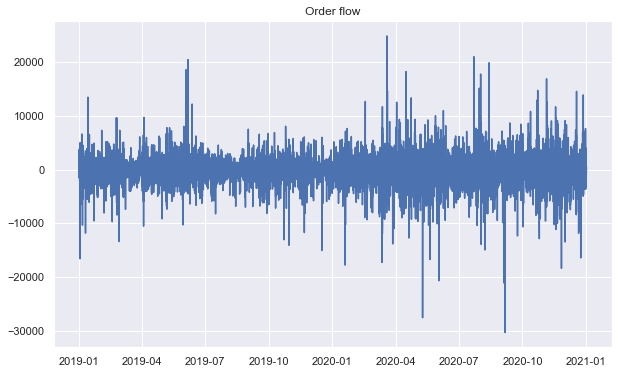

In [13]:
plt.figure(figsize=(10,6))
plt.title('Order flow')
plt.plot(of)
plt.savefig('image/order_flow.jpg')
plt.show();

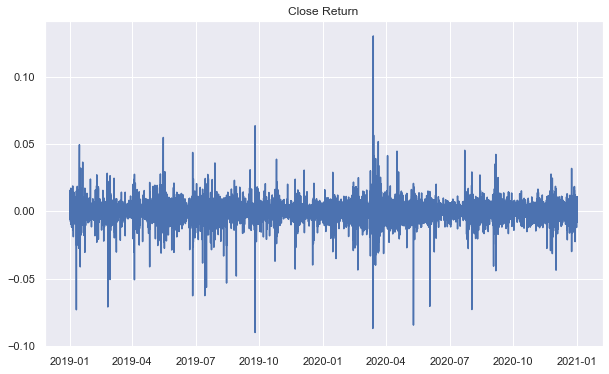

In [14]:
plt.figure(figsize=(10,6))
plt.title('Close Return')
plt.plot(close.pct_change())
plt.savefig('image/closereturn.jpg')
plt.show();

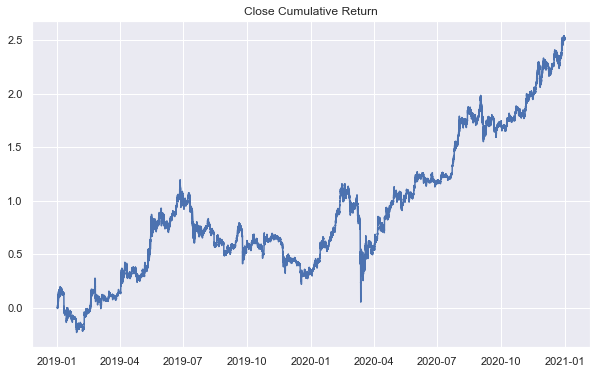

In [15]:
plt.figure(figsize=(10,6))
plt.title('Close Cumulative Return')
plt.plot(np.cumsum(close.pct_change()))
plt.savefig('image/closecumreturn.jpg')
plt.show();

# Getting Signals

 
 I considered only long (up-trend) side.
 
 It is not difficult to do the other side.

## Momentum strategy

In [16]:
windows = np.arange(10,210,10)

For example, let's see the RSI(relative strength index), which is the momentum indicator

I made the threshold to choose when to long or short. 

In [17]:
rsi_df = pd.DataFrame(index=df.index)

In [18]:
for w in windows:
    rsi_df['rsi_{}'.format(w)] = tautil.my_rsi_2(close, w)
rsi_df.dropna(inplace=True)

rsi(14) is often adopted in daily data.

Here is 5 minutes data.

And we have to consider this is crypto data which is far more volatile.


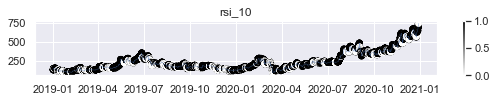

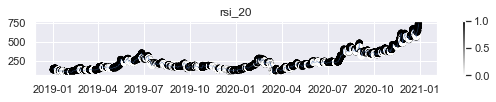

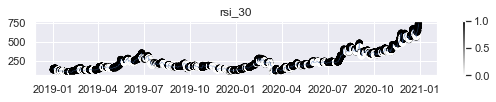

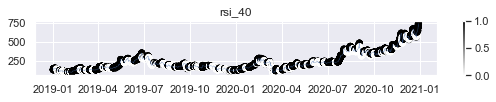

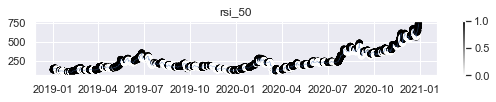

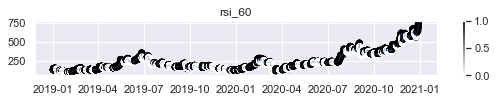

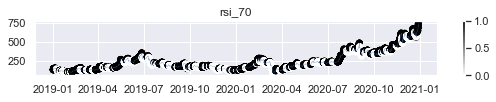

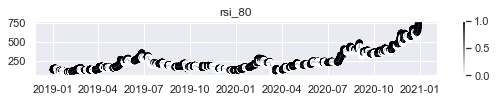

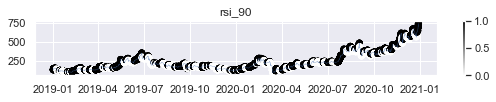

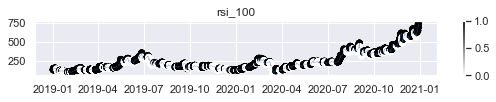

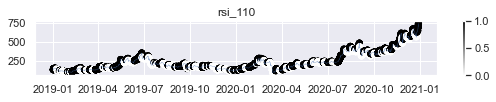

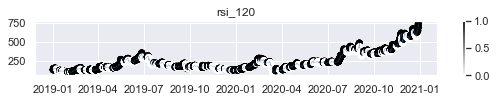

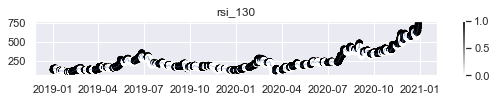

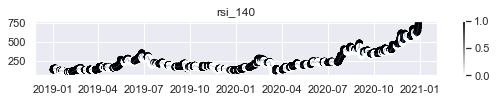

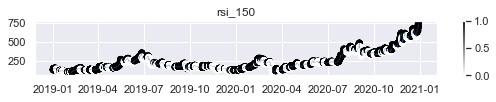

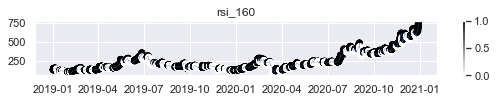

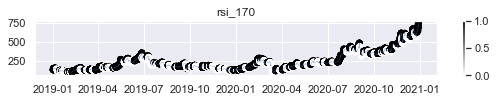

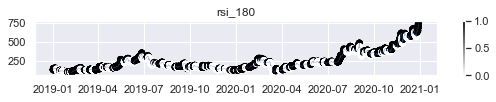

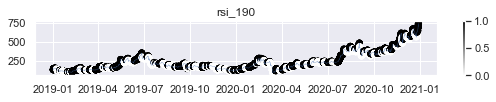

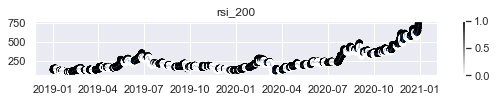

In [19]:
# long signals

for i in rsi_df.columns:
    sc = rsi_df[i].copy()
    plt.figure(figsize=(9,1))
    plt.plot(close.loc[sc.index], linewidth=0.5,alpha=0.6)
    plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap='gray_r', alpha=1, vmin=0,vmax=1)
    plt.colorbar()
    plt.title('{}'.format(i))
    plt.show()

# Labeling with Triple-Barrier Method
 ## Form Symmetric Triple Barrier with signals
 

Below is for testing various windows.

In [20]:
#returns_df = pd.DataFrame()

#for rsi_w in rsi_df.columns:
#    long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
#    enter = long.index
#    pt_sl = [0.05,0.05] # profit-taking, stop-loss target
#    max_holding = [3,0] #[day,hours]
#    barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)
#    returns_df['ret_{}'.format(rsi_w)] = barrier.ret

In [21]:
#for r in returns_df.columns:
#    ret = returns_df[r].dropna()
#    # Intended symmetric returns
#    plt.figure(figsize=(10,6))
#    plt.title('Symmetric returns of Primary Model')
#    plt.bar(ret.index, ret.dropna(),linewidth=0)
#    #plt.savefig('return_of_1stmodel.jpg')
#    plt.show();

In [22]:
#returns_df.cumsum()

For simplicity, I will choose rsi window = 100 for this asset and interval.

You can use other methods, for example combining with MACD.


In [23]:
rsi_w = 'rsi_100'
long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
enter = long.index
pt_sl = [0.05,0.05] # profit-taking, stop-loss target
max_holding = [14,0] #[day,hours]
barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)

Make triple barrier using long signals, profit-taking/stop-loss target returns (must be symmetric), and maximum holding period.

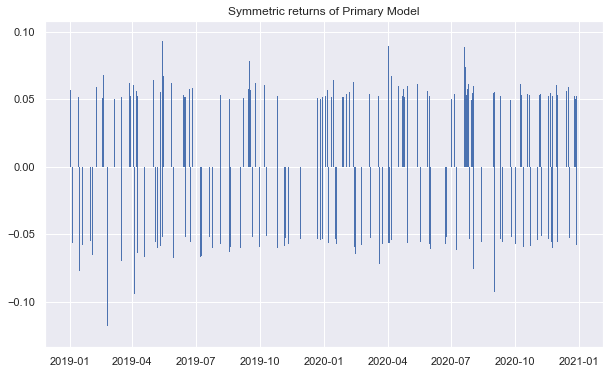

In [24]:
ret = barrier.ret
plt.figure(figsize=(10,6))
plt.title('Symmetric returns of Primary Model')
plt.bar(ret.index, ret.dropna(),linewidth=0)
plt.savefig('image/returns_of_1stmodel.jpg')
plt.show();

You can see the symmetric returns, except for those who exceed max holding periods. 

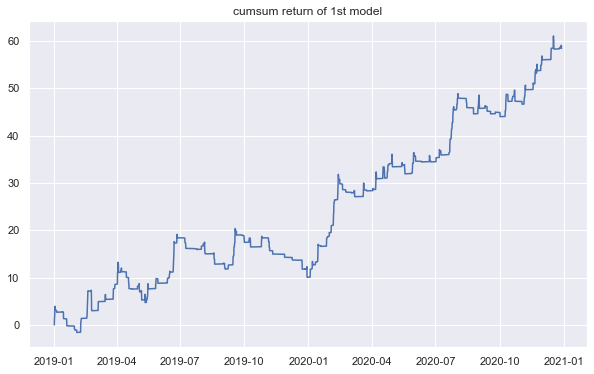

In [25]:
plt.figure(figsize=(10,6))
plt.title('cumsum return of 1st model')
plt.savefig('image/cumsum_return_1stmodel.jpg')
plt.plot(ret.cumsum())
plt.show()

## Binary Labeling (Profit or Loss)

In [26]:
first_model = pd.DataFrame()
first_model['y_pred'] = long
first_model['y_true'] = np.sign(long*barrier.ret)
first_model = first_model.dropna()

y_pred1 = first_model.y_pred
y_true1 = first_model.y_true

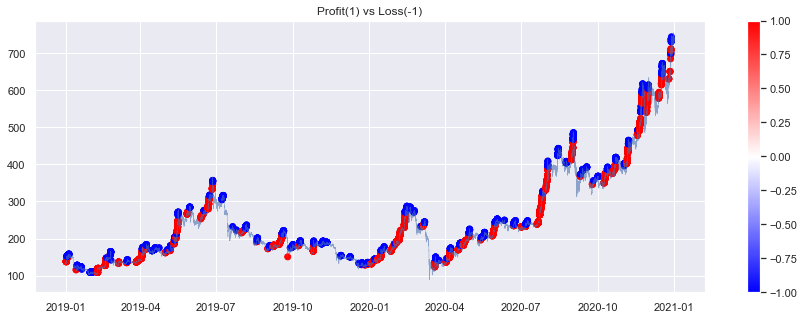

In [27]:
sc = y_true1
title = 'Profit(1) vs Loss(-1)'
figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5))

In [28]:
pnllabel = y_true1.loc[y_true1!=0]
pnllabel.value_counts()

 1.0    2927
-1.0    1673
Name: y_true, dtype: int64

In [29]:
print('Probability of winning: ',pnllabel.value_counts().values[0] / pnllabel.value_counts().values.sum())

Probability of winning:  0.6363043478260869


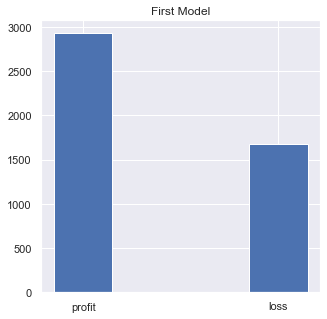

In [30]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],pnllabel.value_counts(), width=0.3)
plt.title('First Model')
plt.savefig('image/pnl_first_model.jpg')
plt.show()

# Prediction Model

For feature engineering we have to split train and test periods.

In [31]:
y = pnllabel.copy().rename('y').to_frame()
train_y = y.loc[:'2020-4-1',:]
test_y = y.loc['2020-4-1':,:]

 ## Get Features (X)
 
 ###  Market data

Market
- Techincal indicators with market data


In [32]:
df_ = df_ohlcv

In [34]:
mts= [5,10,30,60,100] #multipliers
TA = getTA.get_ta_window1(df_,mts)

In [35]:
TA

,aroon_125,aroon_1500,aroon_250,aroon_2500,aroon_750,dpo_100,dpo_1200,dpo_200,dpo_2000,dpo_600,...,rsi_140,rsi_1400,rsi_420,rsi_70,rsi_840,stoch_diff_1400_3,stoch_diff_140_3,stoch_diff_420_3,stoch_diff_70_3,stoch_diff_840_3
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:35:00,61.6,64.933333,-35.6,79.64,45.066667,2.6149,-2.308375,-5.7799,42.434270,12.619550,...,49.649168,51.269918,50.681820,49.309617,51.194552,-0.653008,-1.708230,-2.338868,-8.984911,-1.255872
2020-12-31 23:40:00,61.6,64.933333,-35.6,79.64,45.066667,3.1595,-2.866900,-7.3169,42.144090,9.689350,...,48.919487,51.208847,50.472244,47.728618,51.094894,-1.430637,-7.063121,-5.124085,-19.684499,-2.751414
2020-12-31 23:45:00,61.6,64.933333,-35.6,79.64,45.066667,3.8375,-5.271383,-6.9412,40.411225,9.399383,...,49.311353,51.239203,50.579230,48.601770,51.144623,0.027416,0.143229,0.098197,15.074243,0.052727


First I chose default windows (daily) for each technical indicators/

This is 5 minute data and in first model, I chose rsi_100 instead of rsi_14.

So I will muliply some numbers to the windows. [10,30,50,100]

In [36]:
mkt = TA.copy()

for i in [1,5,10,30]:
    mkt = mkt.join(volume.diff(i).rename('vol_mom_{}'.format(i)))
    mkt = mkt.join(of.diff(i).rename('of_mom_{}'.format(i)))
    mkt = mkt.join(close.diff(i).rename('mom_{}'.format(i)))
    
for i in [5,30,60,100]:
    mkt = mkt.join(close.rolling(i).std().rename('std_{}'.format(i)))
    mkt = mkt.join(volume.rolling(i).std().rename('vol_std_{}'.format(i)))
                   

corr = mkt.corr()
#corr.style.background_gradient(cmap='coolwarm').set_precision(2)

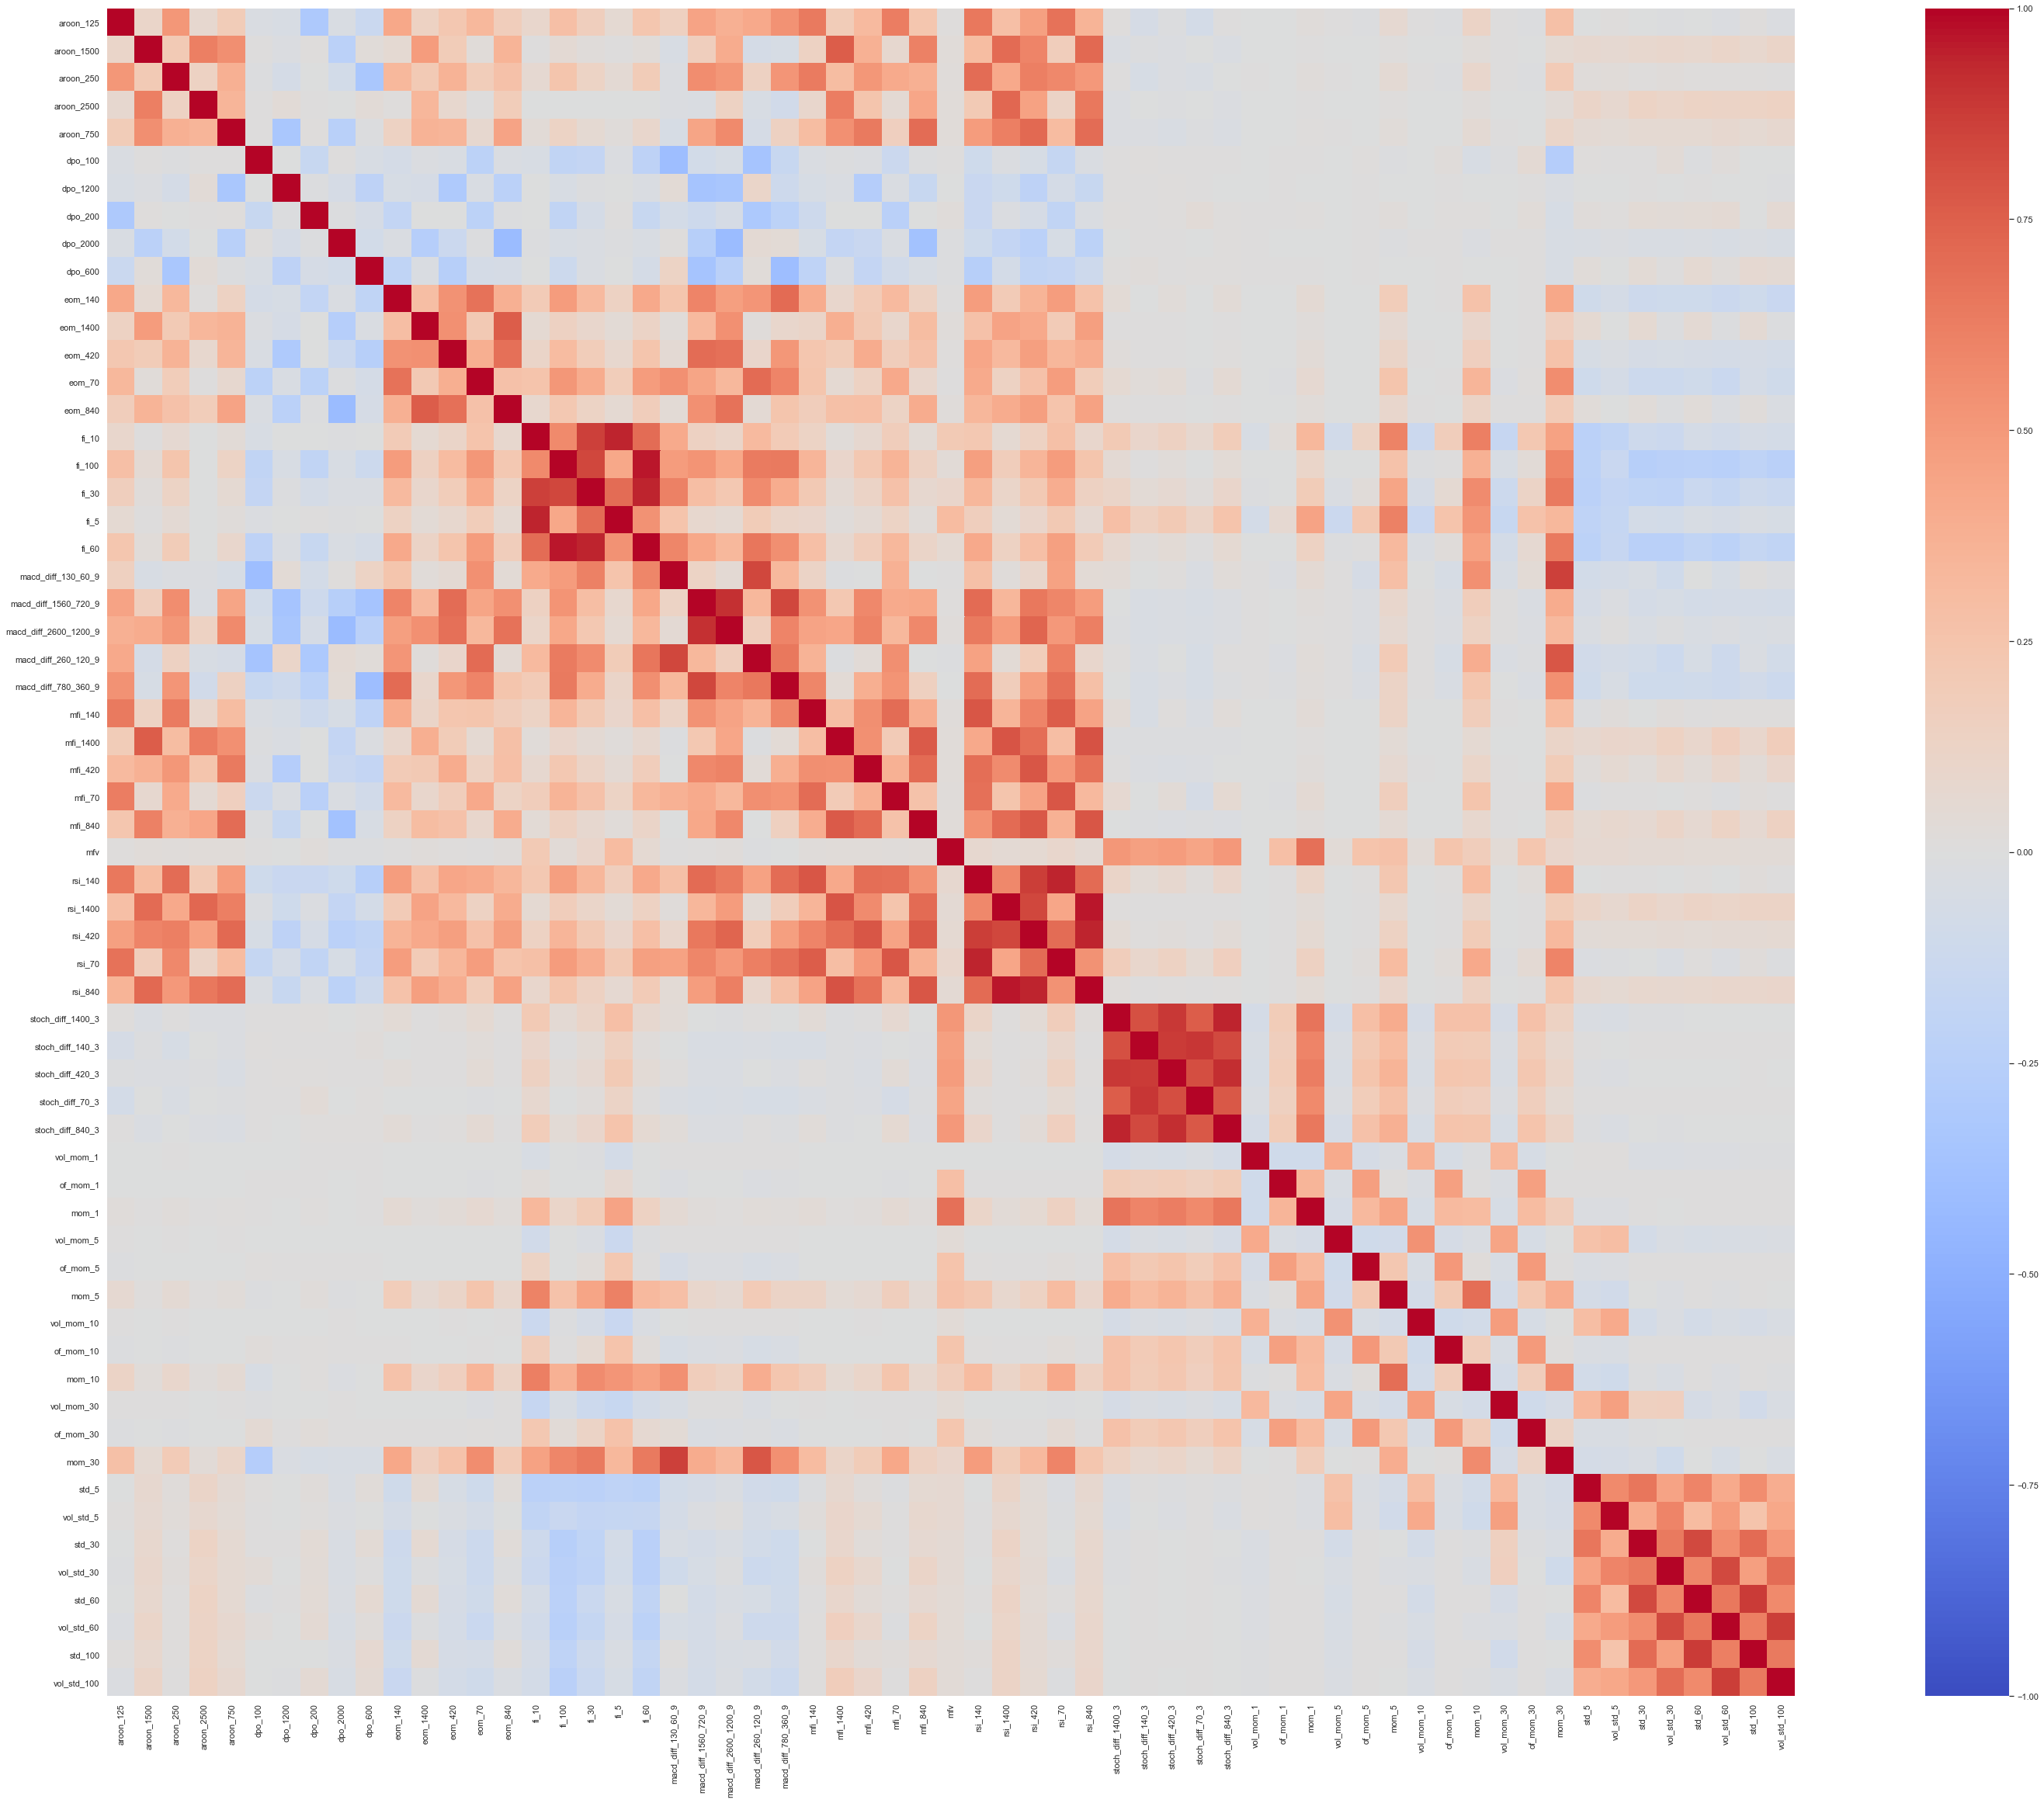

In [37]:
plt.figure(figsize=(60,40))
sns.heatmap(corr, cmap='coolwarm', vmin=-1,vmax=1, square=True)
plt.savefig('image/feature_corr.png')
plt.show()

You can use all features, but I remove some features that are highly linearly correlated.

In [38]:
# Highly correlated market features

h = 0.75
where = (abs(corr)>h) & (corr<1)

hc_list =[]
for i in range(len(np.where(where)[0])):
    hc_list.append(sorted([corr.columns[np.where(where)[0][i]], corr.columns[np.where(where)[1][i]]]))
hc_list = np.array(sorted(hc_list))[::2,:]
hc_list


array([['aroon_1500', 'mfi_1400'],
       ['eom_1400', 'eom_840'],
       ['fi_10', 'fi_30'],
       ['fi_10', 'fi_5'],
       ['fi_100', 'fi_30'],
       ['fi_100', 'fi_60'],
       ['fi_30', 'fi_60'],
       ['macd_diff_130_60_9', 'macd_diff_260_120_9'],
       ['macd_diff_130_60_9', 'mom_30'],
       ['macd_diff_1560_720_9', 'macd_diff_2600_1200_9'],
       ['macd_diff_1560_720_9', 'macd_diff_780_360_9'],
       ['macd_diff_260_120_9', 'mom_30'],
       ['mfi_140', 'rsi_140'],
       ['mfi_140', 'rsi_70'],
       ['mfi_1400', 'mfi_840'],
       ['mfi_1400', 'rsi_1400'],
       ['mfi_1400', 'rsi_840'],
       ['mfi_420', 'rsi_420'],
       ['mfi_70', 'rsi_70'],
       ['mfi_840', 'rsi_420'],
       ['mfi_840', 'rsi_840'],
       ['rsi_140', 'rsi_420'],
       ['rsi_140', 'rsi_70'],
       ['rsi_1400', 'rsi_420'],
       ['rsi_1400', 'rsi_840'],
       ['rsi_420', 'rsi_840'],
       ['std_100', 'std_60'],
       ['std_30', 'std_60'],
       ['stoch_diff_1400_3', 'stoch_diff_140_3'],
 

In [39]:
drop_features = np.unique(hc_list[:,1])
drop_features

array(['eom_840', 'fi_30', 'fi_5', 'fi_60', 'macd_diff_2600_1200_9',
       'macd_diff_260_120_9', 'macd_diff_780_360_9', 'mfi_1400',
       'mfi_840', 'mom_30', 'rsi_140', 'rsi_1400', 'rsi_420', 'rsi_70',
       'rsi_840', 'std_60', 'stoch_diff_140_3', 'stoch_diff_420_3',
       'stoch_diff_70_3', 'stoch_diff_840_3', 'vol_std_60'], dtype='<U21')

In [40]:
mkt1 = mkt.drop(columns=drop_features)
corr2 = mkt1.corr()

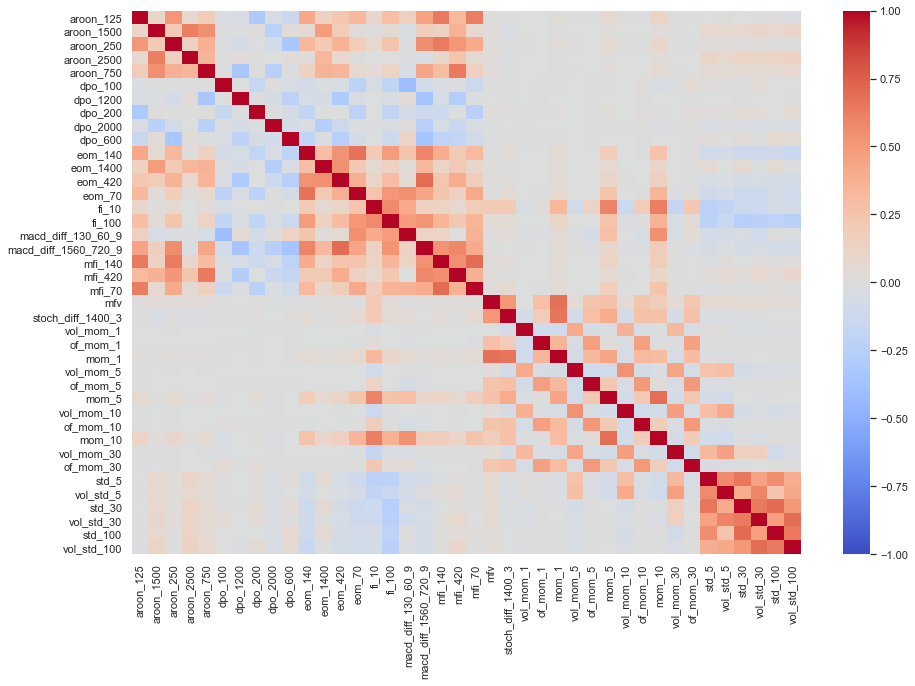

In [41]:
plt.figure(figsize=(15,10))
sns.heatmap(corr2, cmap='coolwarm', vmin=-1,vmax=1)
plt.savefig('image/feature_corr2.png')
plt.show()

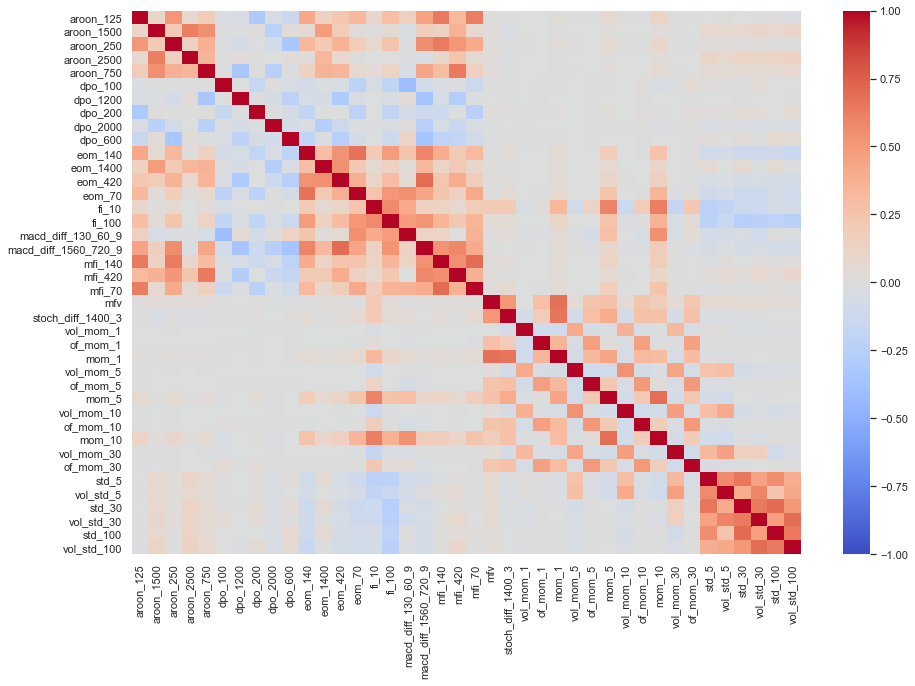

In [42]:
corr2 = mkt1.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr2, cmap='coolwarm', vmin=-1,vmax=1)
plt.savefig('image/feature_corr2.png')
plt.show()

### Market Microstructures

We don't have tick data to build microstructure features.

It would be very helpful with that data.

### Fundamentals

It is not easy to get fundamental data for 5 minutes Ethereum price.

### Sentiments

We can get features from Natural Language Process.

Working on this.

In [43]:
raw_X = mkt1.shift(1).copy()

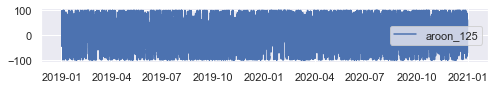

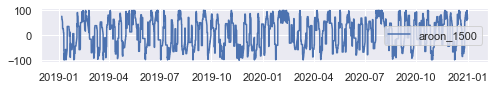

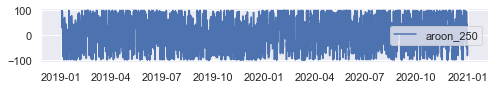

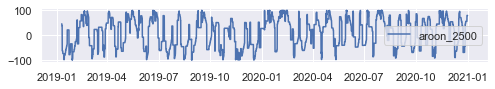

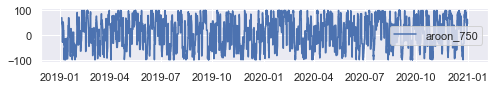

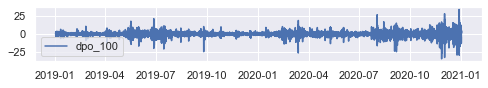

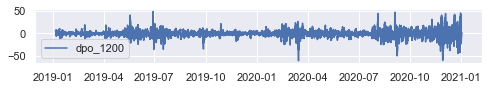

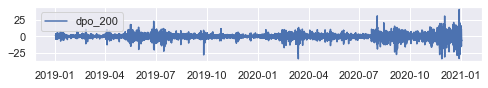

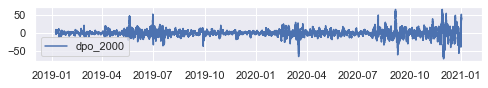

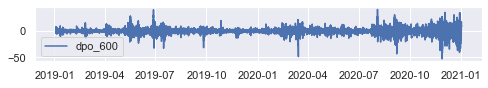

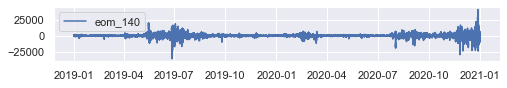

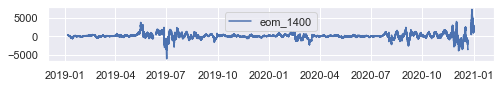

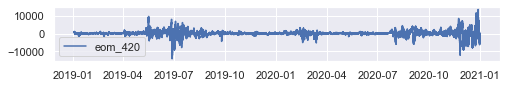

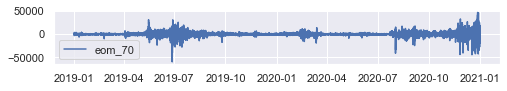

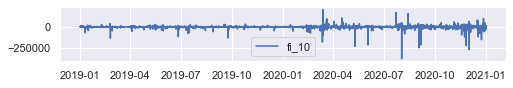

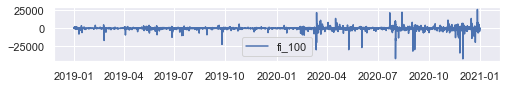

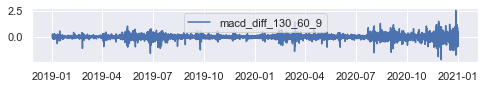

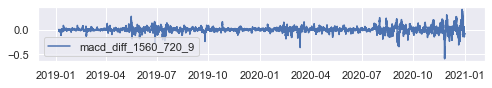

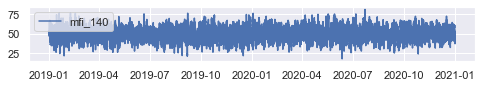

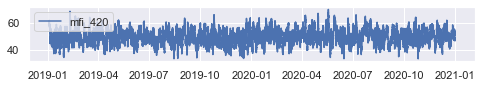

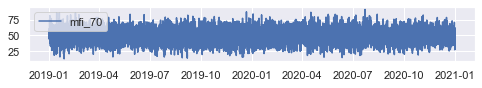

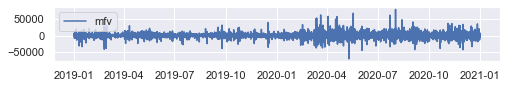

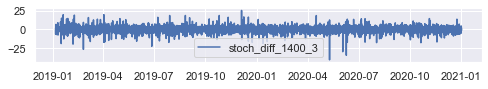

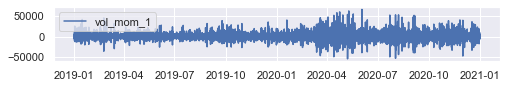

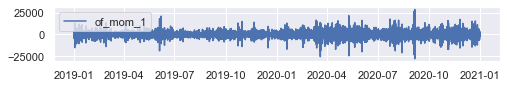

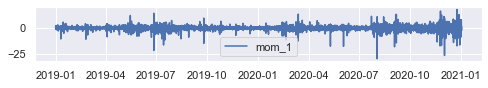

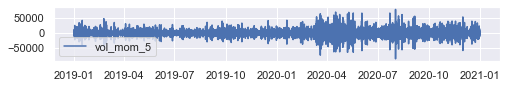

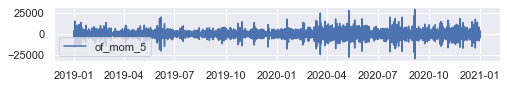

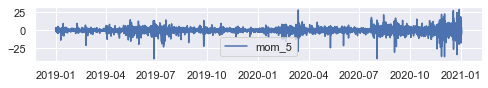

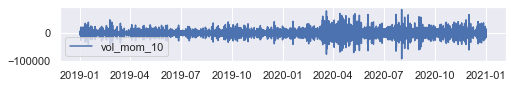

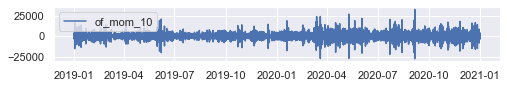

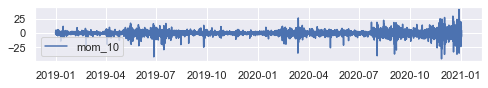

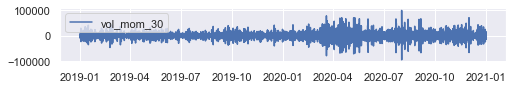

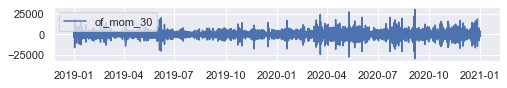

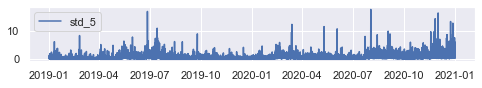

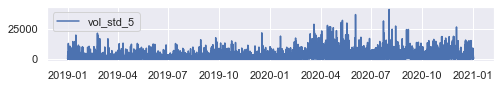

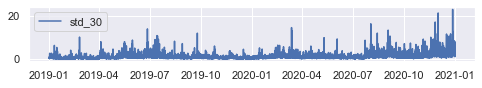

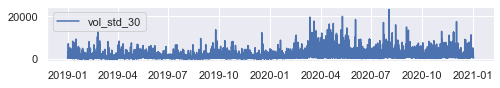

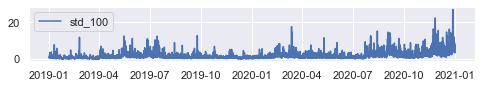

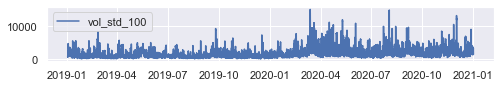

In [44]:
for i in raw_X.columns:
    plt.figure(figsize=(8,1))
    plt.plot(raw_X[i])
    plt.legend([i])

## Feature Engineering

### Feature Scaling

Do it train, test data seperately.
I fit the scaler only on the training dataset and then transform the test set.

*Due to computational cost (in autoencoders), I did scaling and dimension-reduction of index of meta-labels'.*


MINMAX

In [45]:
train_index = y.loc[:'2020-4']
test_index = y.loc['2020-4':]

In [46]:
raw_X_train = raw_X.loc[train_index.index].dropna()
raw_X_test = raw_X.loc[test_index.index].dropna()

In [47]:
scaler = preprocessing.MinMaxScaler((0,1))
scaler.fit(raw_X_train)

scaled_X_train = pd.DataFrame(scaler.transform(raw_X_train),index=raw_X_train.index,columns=raw_X.columns)
scaled_X_test = pd.DataFrame(scaler.transform(raw_X_test),index=raw_X_test.index,columns=raw_X.columns)

### Dimension Reduction
- PCA - linear
- Deep Autoencoder (in process) - non-linear

CNN-autoencoder

https://github.com/jo-cho/machine-learning-for-trading/blob/master/18_convolutional_neural_nets/07_cnn_for_trading.ipynb

https://github.com/jo-cho/ML_Finance_Codes/blob/master/Chapter8-Advanced-NNs/ML_in_Finance-RNNs-Bitcoin.ipynb

In [48]:
# PCA
n=5

pca = PCA(n)
pca.fit(scaled_X_train)

pca_X_train = pd.DataFrame(pca.transform(scaled_X_train),columns = ['pc_{}'.format(i) for i in range(n)], index=scaled_X_train.index)

pca_X_test = pd.DataFrame(pca.transform(scaled_X_test),columns = ['pc_{}'.format(i) for i in range(n)], index=scaled_X_test.index)

In [49]:
components_ = pca.components_

In [50]:
loadings = pd.DataFrame(components_, index = pca_X_train.columns, columns=mkt1.columns).T

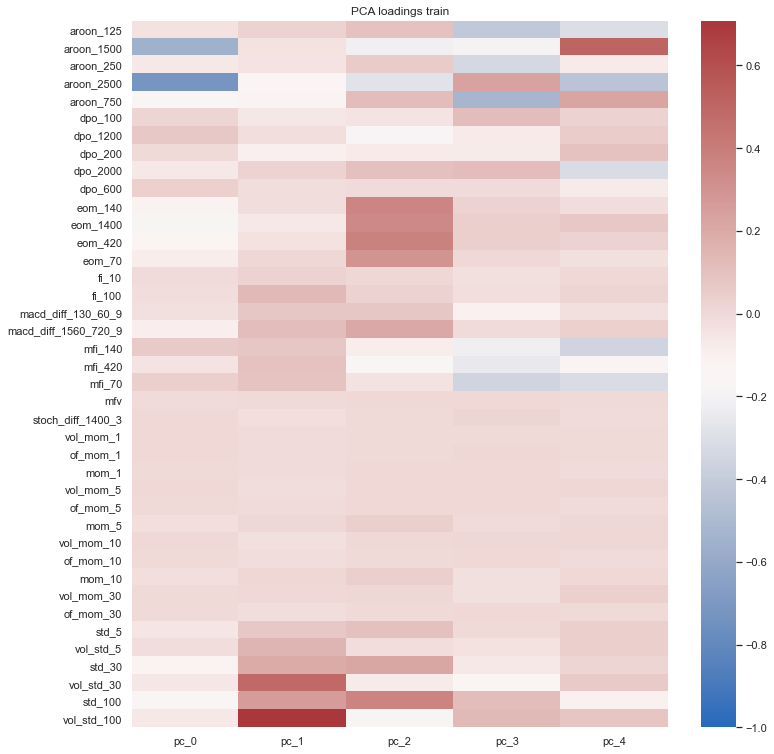

In [51]:
f = plt.figure(figsize=(12, 13))
sns.heatmap(loadings,cmap='vlag',vmin=-1)
plt.title('PCA loadings train')
plt.savefig('image/pcaloadings.jpg')
plt.show();

**Deep Autoencoders**

Non-Linear stacked autoencoders

https://towardsdatascience.com/dimensionality-reduction-with-autoencoders-versus-pca-f47666f80743

In [52]:
x = scaled_X_train.copy()

epochs=100
dimension=5

In [53]:
keras.backend.clear_session()

In [54]:
nl_encoder = keras.models.Sequential([
    keras.layers.Dense(20, input_shape=[x.shape[1]], activation='relu'),
    keras.layers.Dense(15, activation='selu'),
    keras.layers.Dense(dimension, activation='selu'),
])

nl_decoder = keras.models.Sequential([
    keras.layers.Dense(15, input_shape=[dimension], activation='selu'),
    keras.layers.Dense(20, activation='selu'),
    keras.layers.Dense(x.shape[1], activation='relu'),
])

nl_autoencoder = keras.models.Sequential([nl_encoder, nl_decoder])
nl_autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(lr=0.1, decay=1e-4))
nl_autoencoder.summary()


history = nl_autoencoder.fit(x,x, epochs=epochs, callbacks=[keras.callbacks.EarlyStopping(monitor='loss',patience=10)],
                             verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 5)                 1215      
_________________________________________________________________
sequential_1 (Sequential)    (None, 40)                1250      
Total params: 2,465
Trainable params: 2,465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.1420
Epoch 2/100
91/91 [==============================] - 0s 3ms/step - loss: 0.1039
Epoch 3/100
91/91 [==============================] - 0s 2ms/step - loss: 0.1040
Epoch 4/100
91/91 [==============================] - 0s 2ms/step - loss: 0.1040
Epoch 5/100
91/91 [==============================] - 0s 3ms/step - loss: 0.1035
Epoch 6/100
91/91 [==============================] - 0s 3ms/step - loss: 0.1035
Epoch 7/100
91/91 [===============

91/91 [==============================] - 0s 2ms/step - loss: 0.0924
Epoch 95/100
91/91 [==============================] - 0s 2ms/step - loss: 0.0925
Epoch 96/100
91/91 [==============================] - 0s 2ms/step - loss: 0.0924
Epoch 97/100
91/91 [==============================] - 0s 2ms/step - loss: 0.0928
Epoch 98/100
91/91 [==============================] - 0s 2ms/step - loss: 0.0928
Epoch 99/100
91/91 [==============================] - 0s 2ms/step - loss: 0.0927
Epoch 100/100
91/91 [==============================] - 0s 2ms/step - loss: 0.0927


In [55]:
encoded_X_train = nl_encoder.predict(scaled_X_train)
encoded_X_train = pd.DataFrame(encoded_X_train, index=scaled_X_train.index,columns=['encoded_{}'.format(i) for i in range(dimension)])

encoded_X_test = nl_encoder.predict(scaled_X_test)
encoded_X_test = pd.DataFrame(encoded_X_test, index=scaled_X_test.index,columns=['encoded_{}'.format(i) for i in range(dimension)])

In [56]:
encoded_X_train

,encoded_0,encoded_1,encoded_2,encoded_3,encoded_4
timestamp,,,,,
2019-01-13 16:10:00,-0.379681,0.602802,0.388018,0.433417,-0.832889
2019-01-13 16:20:00,-0.020638,0.557827,0.330296,0.403818,-0.832077
2019-01-14 19:50:00,-0.406743,1.563363,0.685634,0.471896,-1.205209
2019-01-14 22:00:00,-0.140839,1.389048,0.707574,0.460553,-1.198695
2019-01-14 22:05:00,-0.211587,1.444732,0.748574,0.521046,-1.174437
...,...,...,...,...,...
2020-04-30 05:25:00,-0.396726,2.173983,1.692818,1.247340,-1.026267
2020-04-30 05:35:00,-0.469063,2.166964,1.713939,1.203366,-1.069770
2020-04-30 05:40:00,-0.410607,2.159560,1.702765,1.233964,-1.040671


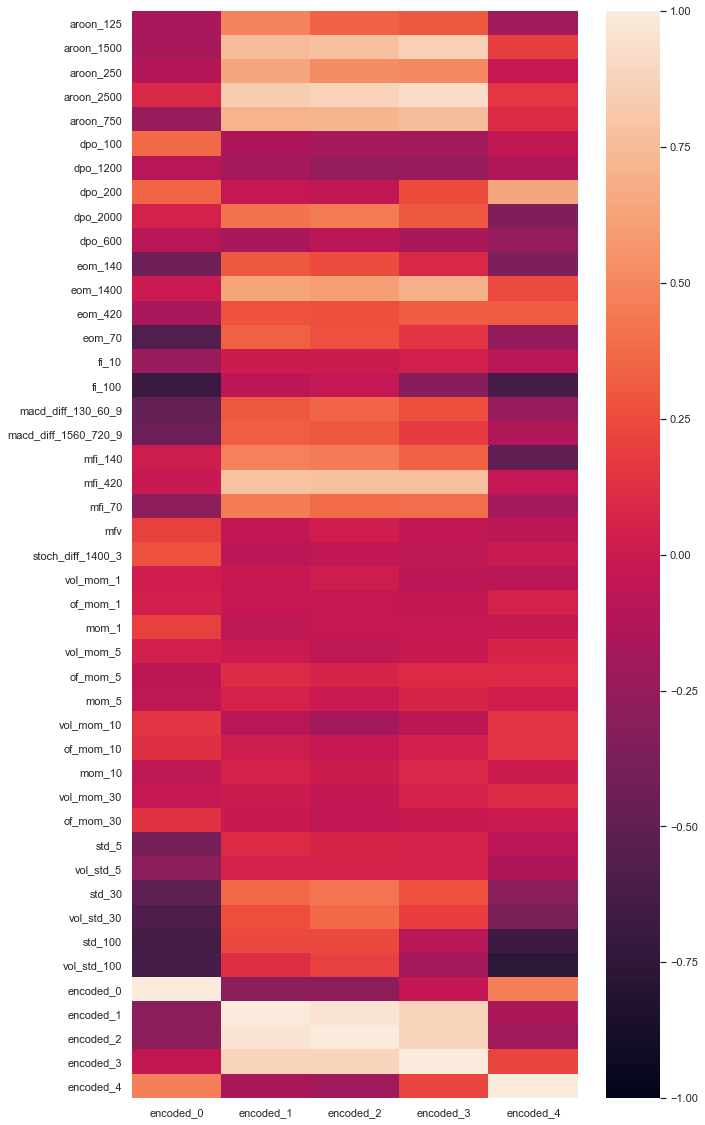

In [57]:
corr_encoded = scaled_X_test.join(encoded_X_train).corr().iloc[-5:].T

plt.figure(figsize=(10,20))
sns.heatmap(corr_encoded,vmin=-1,vmax=1)
plt.show()

COMPARE PCA and Non-linear autoencoder

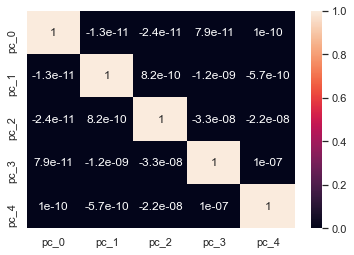

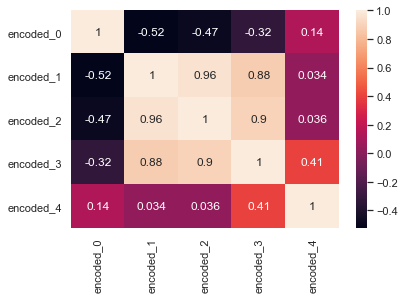

In [58]:
# correlation (linearly)
sns.heatmap(pca_X_train.corr(),annot=True)
plt.show()

sns.heatmap(encoded_X_train.corr(),annot=True)
plt.show()

# Machine Learning Model

## Hyper parameter tuning

We have to focus on **precision score**(in symmetric barrier) or **f1 score**

because

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, it helps.

or F1 socre in general(*suggested by De Prado): Accuracy may not be an adequate classification score for meta-labeling
applications. 
- Suppose that, after you apply meta-labeling, there are many more
negative cases (label ‘0’) than positive cases (label ‘1’). Under that scenario, a
classifier that predicts every case to be negative will achieve high accuracy, even
though recall=0 and precision is undefined. The F1 score corrects for that flaw,
by assessing the classifier in terms of the (equally weighted) harmonic mean of
precision and recall,

In [59]:
train_X = pca_X_train.copy() 
# or
#train_X= encoded_X_train.copy()

test_X = pca_X_test.copy()
# or
#test_X= encoded_X_test.copy()<Increasing p (probability of winning)>

FYI using encoded_X, the best precision score of auto ML models is around 0.66

In [60]:
train_data = train_X.join(train_y).dropna()
test_data = test_X.join(test_y).dropna()

## AutoML with autogluon and select the best model

In [61]:
from autogluon.tabular import TabularPredictor

We have to focus on **precision score**(in symmetric barrier) or **f1 score**

because

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, this helps.

or F1 socre (*suggested by De Prado): Accuracy may not be an adequate classification score for meta-labeling
applications. Suppose that, after you apply meta-labeling, there are many more
negative cases (label ‘0’) than positive cases (label ‘1’). Under that scenario, a
classifier that predicts every case to be negative will achieve high accuracy, even
though recall=0 and precision is undefined. The F1 score corrects for that flaw,
by assessing the classifier in terms of the (equally weighted) harmonic mean of
precision and recall,

This *autogluon* supports a number of machine learning models, and automatically chooses optimal hyperparameters given which score to be optimized.

And also it does CV, but not Purged K-Fold which was suggested by De Prado

So we choose precision score to be maximized. (but there are some problems with *n*(annual betting opportuinites).)

In [62]:
predictor = TabularPredictor(label='y', eval_metric='precision').fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20210804_140038\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210804_140038\"
AutoGluon Version:  0.2.0
Train Data Rows:    2533
Train Data Columns: 5
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, -1.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1.0, class 0 = -1.0
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive (1.0) vs negative (-1.0) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipel

[23:00:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


	0.9553	 = Validation precision score
	1.34s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetMXNet ...
		Unable to import dependency mxnet. A quick tip is to install via `pip install mxnet --upgrade`, or `pip install mxnet_cu101 --upgrade`
Fitting model: LightGBMLarge ...
	0.955	 = Validation precision score
	1.9s	 = Training runtime
	0.0s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	0.9675	 = Validation precision score
	1.19s	 = Training runtime
	0.01s	 = Validation runtime
AutoGluon training complete, total runtime = 20.33s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20210804_140038\")


limitation
- shuffle 
- not good cv for finance data

In [63]:
result = predictor.leaderboard(test_data, silent=True)
result

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,0.662245,0.954984,0.027925,0.004987,1.901912,0.027925,0.004987,1.901912,1,True,12
1,LightGBM,0.660999,0.964516,0.036865,0.005984,1.973720,0.036865,0.005984,1.973720,1,True,4
2,NeuralNetFastAI,0.658215,0.869048,0.042885,0.019947,3.746976,0.042885,0.019947,3.746976,1,True,10
3,LightGBMXT,0.656577,0.951923,0.024933,0.007979,3.858228,0.024933,0.007979,3.858228,1,True,3
4,RandomForestEntr,0.653643,0.952229,0.136635,0.121664,0.529612,0.136635,0.121664,0.529612,1,True,6
5,XGBoost,0.651515,0.955272,0.104692,0.012965,1.338419,0.104692,0.012965,1.338419,1,True,11
6,ExtraTreesEntr,0.650709,0.964516,0.131027,0.120677,0.415889,0.131027,0.120677,0.415889,1,True,9
7,RandomForestGini,0.648734,0.958466,0.119807,0.233696,0.456012,0.119807,0.233696,0.456012,1,True,5
8,CatBoost,0.645596,0.961039,0.005984,0.006982,1.923853,0.005984,0.006982,1.923853,1,True,7
9,ExtraTreesGini,0.643744,0.964516,0.165090,0.106715,0.419877,0.165090,0.106715,0.419877,1,True,8


In [64]:
best_model = result.model[0]

In [65]:
y_true2 = test_data.y
y_pred2 = predictor.predict(test_data, model=best_model)

print(best_model, "'s predictions:  \n", y_pred2)
perf = predictor.evaluate_predictions(y_true=y_true2, y_pred=y_pred2, auxiliary_metrics=True)

Evaluation: precision on test data: 0.6622448979591836
Evaluations on test data:
{
    "precision": 0.6622448979591836,
    "accuracy": 0.5089514066496164,
    "balanced_accuracy": 0.5094515063464655,
    "mcc": 0.017987691954361108,
    "f1": 0.574844995571302,
    "recall": 0.5078247261345853
}


LightGBMLarge 's predictions:  
 timestamp
2020-04-02 00:15:00    1.0
2020-04-02 00:20:00    1.0
2020-04-02 00:25:00    1.0
2020-04-02 00:30:00    1.0
2020-04-02 00:40:00    1.0
                      ... 
2020-12-28 09:15:00   -1.0
2020-12-28 09:20:00   -1.0
2020-12-28 09:25:00   -1.0
2020-12-28 09:40:00   -1.0
2020-12-28 16:15:00    1.0
Name: y, Length: 1955, dtype: float64


## Feature Importance

In autogluon,

- A feature's importance score represents the performance drop that results when the model makes predictions on a perturbed copy of the data where this feature's values have been randomly shuffled across rows.
- A feature score of 0.01 would indicate that the predictive performance dropped by 0.01 when the feature was randomly shuffled.
- The higher the score a feature has, the more important it is to the model's performance.
- If a feature has a negative score, this means that the feature is likely harmful to the final model, and a model trained with the feature removed would be expected to achieve a better predictive performance.

In [66]:
for i in result.model:
    print(i, "'s Feature Importance")
    fi = predictor.feature_importance(test_data, model=i, silent=True)
    print(fi)
    print('\n')

LightGBMLarge 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_4    0.036684  0.016798  0.031662  3  0.132936 -0.059568
pc_1    0.002482  0.010980  0.366609  3  0.065399 -0.060435
pc_3   -0.002038  0.012412  0.598597  3  0.069082 -0.073159
pc_0   -0.011596  0.021154  0.778699  3  0.109621 -0.132813
pc_2   -0.029277  0.014491  0.963575  3  0.053758 -0.112313


LightGBM 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_4    0.035601  0.010157  0.013038  3  0.093801 -0.022600
pc_3   -0.000277  0.012672  0.513394  3  0.072333 -0.072887
pc_0   -0.004164  0.012516  0.688659  3  0.067554 -0.075881
pc_1   -0.004417  0.001501  0.981797  3  0.004185 -0.013020
pc_2   -0.018737  0.002323  0.997457  3 -0.005424 -0.032050


NeuralNetFastAI 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_4    0.010804  0.000370  0.000196  3  0.012926  0.008682
pc_0    0.006673  0.012487  0.226193  3  0.078224 -

## Results with PnL

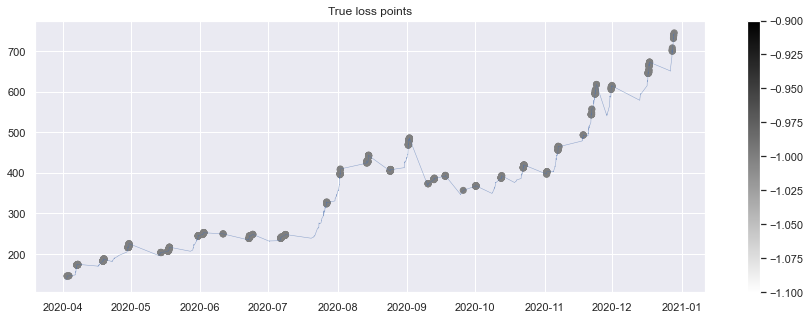

In [67]:
sc = y_true2.loc[y_true2==-1]
title = 'True loss points'
figure_scatter(sc,close.loc[y_true2.index],title,cmap='gray_r')

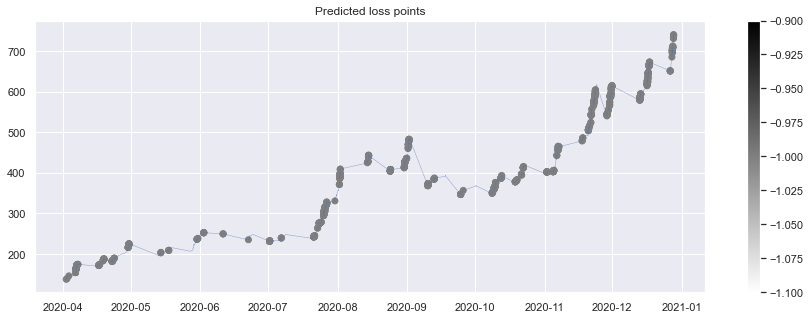

In [68]:
sc = y_pred2.loc[y_pred2==-1]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [69]:
# After drop predicted loss
predlabel = y_true2.drop(index=y_pred2.loc[y_pred2==-1].index)
predlabel.value_counts()

 1.0    649
-1.0    331
Name: y, dtype: int64

In [70]:
print('이익확률 pi: ',predlabel.value_counts().values[0] / predlabel.value_counts().values.sum())\

이익확률 pi:  0.6622448979591836


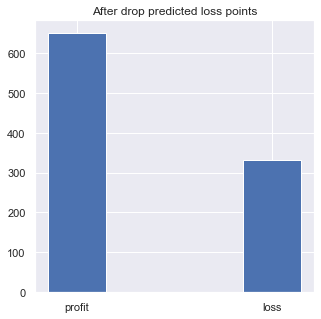

In [71]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel.value_counts(), width=0.3)
plt.title('After drop predicted loss points')
plt.savefig('image/pnl_2nd.png')
plt.show()

the pitfalls of maximizing precision score:

there can be huge diminish in bet opportunities.

Using Predicted Probabilities adjust it.
from 0.5 to maybe 0.8

In [72]:
y_pred_prob2 = predictor.predict_proba(test_data)
y_pred_prob2

,-1.0,1.0
timestamp,,
2020-04-02 00:15:00,0.0,1.0
2020-04-02 00:20:00,0.0,1.0
2020-04-02 00:25:00,0.0,1.0
2020-04-02 00:30:00,0.0,1.0
2020-04-02 00:40:00,0.0,1.0
...,...,...
2020-12-28 09:15:00,1.0,0.0
2020-12-28 09:20:00,1.0,0.0
2020-12-28 09:25:00,1.0,0.0


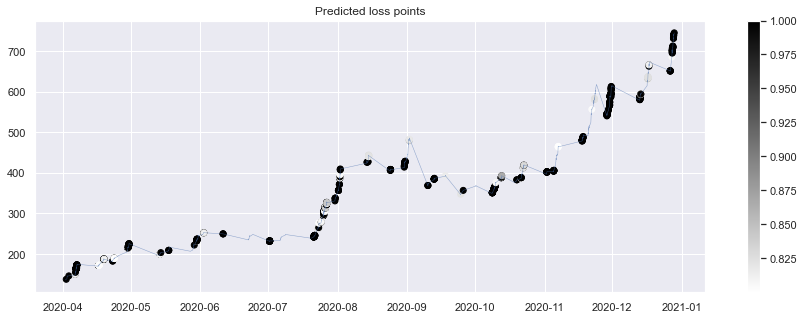

In [73]:
pred_loss = y_pred_prob2[-1]
sc = pred_loss.loc[pred_loss>0.8]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [74]:
# After drop predicted loss
predlabel2 = y_true2.drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>=0.8].index)
predlabel2.value_counts()

 1.0    792
-1.0    477
Name: y, dtype: int64

In [75]:
print('이익확률 pi: ',predlabel2.value_counts().values[0] / predlabel2.value_counts().values.sum())\

이익확률 pi:  0.624113475177305


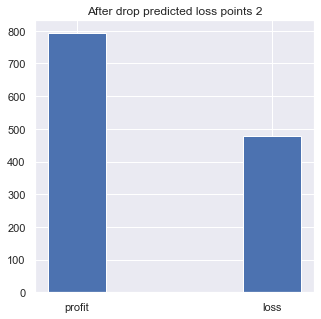

In [76]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel2.value_counts(), width=0.3)
plt.title('After drop predicted loss points 2')
plt.savefig('image/pnl_2nd2.png')
plt.show()

Solution (in process):

When choosing the optimal model, consider not only precision score but also the number of betting opportunities.

More specifically maximizing annualized Sharpe ratio.


see returns

In [77]:
finret = ret.loc[y_true2.index].drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>0.5].index)
finret

timestamp
2020-04-02 00:15:00    0.051778
2020-04-02 00:20:00    0.050457
2020-04-02 00:25:00    0.052732
2020-04-02 00:30:00    0.049944
2020-04-02 00:40:00    0.049651
                         ...   
2020-12-17 16:50:00   -0.052394
2020-12-17 16:55:00   -0.052423
2020-12-17 17:00:00   -0.051486
2020-12-17 17:05:00   -0.052275
2020-12-17 17:10:00   -0.051858
Name: ret, Length: 1010, dtype: float64

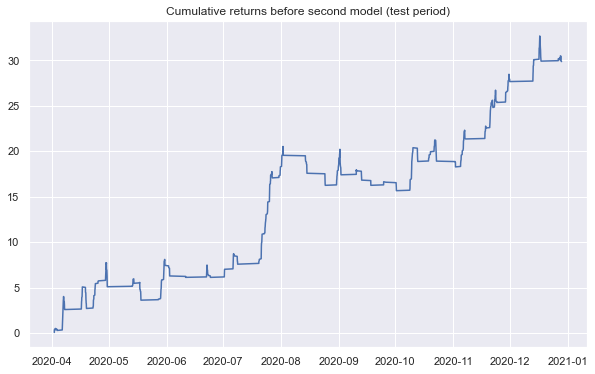

In [78]:
plt.figure(figsize=(10,6))
plt.title('Cumulative returns before second model (test period)')
plt.plot(ret.loc[y_true2.index].cumsum())
plt.savefig('image/cumsum_ret_1st_test.png')
plt.show()

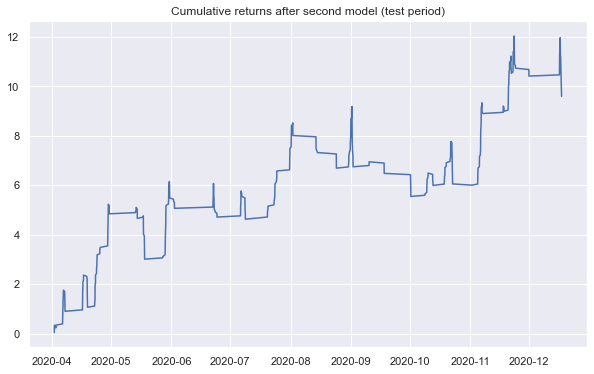

In [79]:
plt.figure(figsize=(10,6))
plt.title('Cumulative returns after second model (test period)')
plt.plot(finret.cumsum())
plt.savefig('image/cumsum_ret_2nd_test.png')
plt.show()

### Trading

#### bet sizing

- Kelly rules (when betting data is normally dist.)
- Use predicted probabilities as bet confidence (suggested by DePrado)

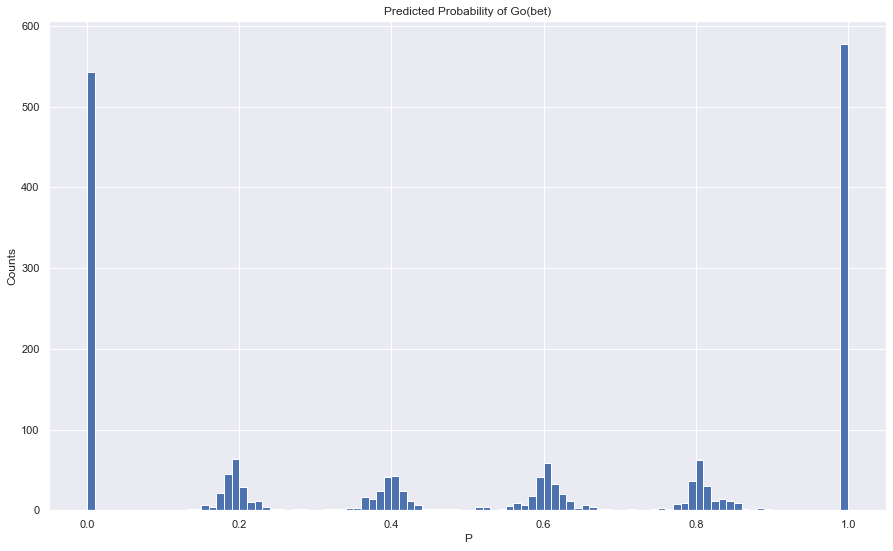

In [80]:
p = y_pred_prob2[1]
f=plt.figure(figsize=(15,9))
a = f.gca()
a.hist(p,bins=100)
plt.xlabel('P')
plt.ylabel('Counts')
plt.title('Predicted Probability of Go(bet)')
plt.savefig('image/predprob.jpg')
plt.show()

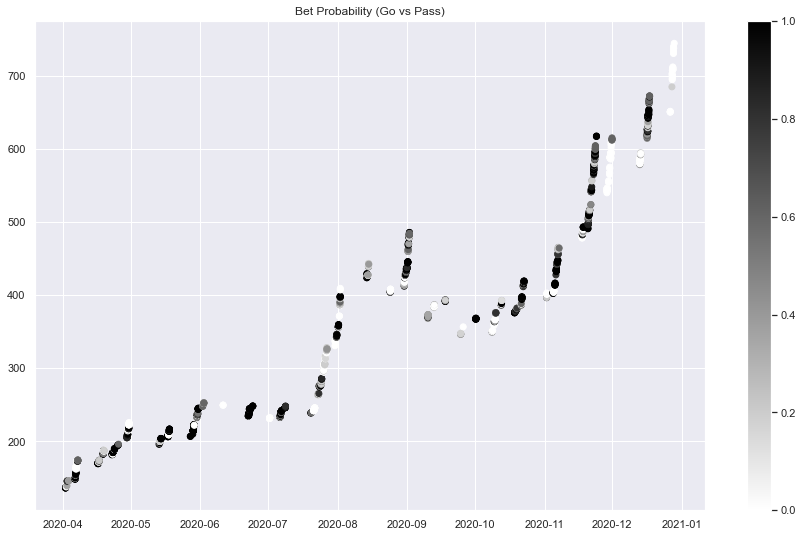

In [81]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_true2.index, close.loc[y_true2.index] ,c= p, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Probability (Go vs Pass)')
plt.savefig('image/bet_prob.png')
plt.show()

## Bet Sizing

- not perfect yet

In [82]:
def get_signal(prob, num_classes):
    if prob.shape[0] == 0:
        return pd.Series(dtype='float64')

    bet_sizes = (prob - 1/num_classes) / (prob * (1 - prob))**0.5

    bet_sizes = bet_sizes.apply(lambda s: 2 * norm.cdf(s) - 1)

    return bet_sizes

In [83]:
def discretize(signal0, step_size):
    signal1 = (signal0 / step_size).round() * step_size
    signal1[signal1 > 1] = 1  # Cap
    signal1[signal1 < -1] = -1  # Floor
    return signal1

In [84]:
prob = p.copy()

m = get_signal(prob, 2)
m = discretize(m, 0.25)

In [85]:
m

timestamp
2020-04-02 00:15:00    1.0
2020-04-02 00:20:00    1.0
2020-04-02 00:25:00    1.0
2020-04-02 00:30:00    1.0
2020-04-02 00:40:00    1.0
                      ... 
2020-12-28 09:15:00   -1.0
2020-12-28 09:20:00   -1.0
2020-12-28 09:25:00   -1.0
2020-12-28 09:40:00   -1.0
2020-12-28 16:15:00   -1.0
Name: 1.0, Length: 1955, dtype: float64

In [86]:
# we only do long position betting

m.loc[m[m<0].index] = 0
m

timestamp
2020-04-02 00:15:00    1.0
2020-04-02 00:20:00    1.0
2020-04-02 00:25:00    1.0
2020-04-02 00:30:00    1.0
2020-04-02 00:40:00    1.0
                      ... 
2020-12-28 09:15:00    0.0
2020-12-28 09:20:00    0.0
2020-12-28 09:25:00    0.0
2020-12-28 09:40:00    0.0
2020-12-28 16:15:00    0.0
Name: 1.0, Length: 1955, dtype: float64

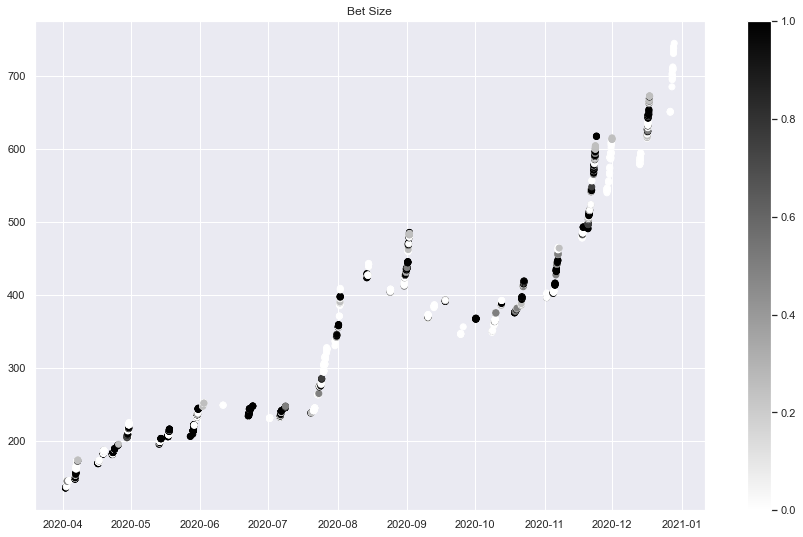

In [87]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_true2.index, close.loc[y_true2.index] ,c= m, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Size')
plt.savefig('image/betsize.jpg')
plt.show()

## Results

### Backtest with zipline/pyfolio

We are not ready for the portfolio optimization.

Here, let us say there are only two assets (ETH and cash)

In [88]:
barrier_t = barrier.loc[y_true2.index]

In [89]:
initial_money=100_000
bet_size = m*initial_money

In [90]:
wallet = tb.get_wallet(close,barrier_t,initial_money, bet_size)
wallet

,exit,price,money_spent,money_receive,buy_amount,sell_amount,n_stock,cash_inventory
timestamp,,,,,,,,
2020-04-02 00:15:00,2020-04-02 16:55:00,136.24,13624000.0,0.000000e+00,100000.0,0.0,100000.0,-1.352400e+07
2020-04-02 00:20:00,2020-04-02 16:55:00,136.42,13642000.0,0.000000e+00,100000.0,0.0,200000.0,-2.716600e+07
2020-04-02 00:25:00,2020-04-02 16:55:00,136.11,13611000.0,0.000000e+00,100000.0,0.0,300000.0,-4.077700e+07
2020-04-02 00:30:00,2020-04-02 16:55:00,136.49,13649000.0,0.000000e+00,100000.0,0.0,400000.0,-5.442600e+07
2020-04-02 00:40:00,2020-04-02 16:55:00,136.53,13653000.0,0.000000e+00,100000.0,0.0,500000.0,-6.807900e+07
...,...,...,...,...,...,...,...,...
2020-12-17 18:15:00,0,638.03,0.0,7.975375e+07,0.0,125000.0,2525000.0,-1.332723e+09
2020-12-17 21:05:00,0,637.24,0.0,6.372400e+07,0.0,100000.0,2425000.0,-1.268999e+09
2020-12-17 21:20:00,0,627.84,0.0,1.883520e+08,0.0,300000.0,2125000.0,-1.080647e+09


- I made this function for only stocks. For cryptocurrency your buy amount or sell amount can be float.
- There is still error in bet sizing. This function calculate buy amount as *bet_size* * *initial_cash*. It should be *bet_size* * *cash_inventory*.

In [91]:
eth_position = wallet.money_spent-wallet.money_receive
cash_position = wallet.cash_inventory.diff()

In [92]:
positions = pd.DataFrame()
positions['ETH'] = eth_position
positions['cash'] = cash_position

In [93]:
positions

,ETH,cash
timestamp,,
2020-04-02 00:15:00,1.362400e+07,NaN
2020-04-02 00:20:00,1.364200e+07,-1.364200e+07
2020-04-02 00:25:00,1.361100e+07,-1.361100e+07
2020-04-02 00:30:00,1.364900e+07,-1.364900e+07
2020-04-02 00:40:00,1.365300e+07,-1.365300e+07
...,...,...
2020-12-17 18:15:00,-7.975375e+07,7.975375e+07
2020-12-17 21:05:00,-6.372400e+07,6.372400e+07
2020-12-17 21:20:00,-1.883520e+08,1.883520e+08


In [94]:
ret = barrier_t.ret
ret

timestamp
2020-04-02 00:15:00    0.051778
2020-04-02 00:20:00    0.050457
2020-04-02 00:25:00    0.052732
2020-04-02 00:30:00    0.049944
2020-04-02 00:40:00    0.049651
                         ...   
2020-12-28 09:15:00   -0.052281
2020-12-28 09:20:00   -0.052836
2020-12-28 09:25:00   -0.053338
2020-12-28 09:40:00   -0.051779
2020-12-28 16:15:00   -0.052172
Name: ret, Length: 1955, dtype: float64

In [95]:
#pyfolio only supports daily returns

ret_daily = ret.resample('D').sum()
positions_daily = positions.resample('D').sum()

In [96]:
#pf.create_full_tear_sheet(ret_daily, positions=positions_daily)

# Further Study

Feature Analysis: 
    - How to efficiently extract information from various market features using deep learning.